In [31]:
import matplotlib.pyplot as plt
import seaborn
import pandas
import sys
import numpy as np
from scipy import stats
from collections import Counter

# this tells seaborn and matplotlib to generate plots inline in the notebook
%matplotlib inline  

# these two lines allow you to control the figure size
%pylab inline
pylab.rcParams['figure.figsize'] = (16.0, 8.0) 
 
ur = pandas.read_csv('data/movie/user_ratedmovies_train.dat','\t')
predictions = pandas.read_csv('data/movie/predictions.dat', '\t')

# create a test/train split
 
all_inds = np.random.permutation( range(0,len(ur)) )
## VALIDATION SET FOR TESTING
test_inds = all_inds[0:10]
train_inds = all_inds[10:len(ur)]
 
ur_test = ur.iloc[ test_inds ]
ur_train = ur.iloc[ train_inds ]

Populating the interactive namespace from numpy and matplotlib


In [33]:
def get_two_user_data(userID1, userID2):
    return ur_train.query("userID == %d or userID == %d" % (userID1, userID2))

def get_intersection_list(user_data):
    movies_rated = user_data['movieID']
    cnt = Counter(movies_rated)
    return [k for k, v in cnt.iteritems() if v > 1]    

def get_intersection_data(user_data, intersection_list):
    return user_data[user_data['movieID'].isin(intersection_list)]

def most_common(lst):
    return max(set(lst), key=lst.count)

def get_relationship_strength(user1, user2):
    user_data = get_two_user_data(user1, user2)
    intersection_list = get_intersection_list(user_data)
    if len(intersection_list) == 0: return 1
    intersection_data = get_intersection_data(user_data, intersection_list)
    
    user1Ratings = intersection_data[intersection_data['userID'] == user1].sort_values('movieID')['rating']
    user2Ratings = intersection_data[intersection_data['userID'] == user2].sort_values('movieID')['rating']
    
    sse = get_euclid(user1Ratings, user2Ratings)
    return sse / len(intersection_list)

def guess_with_k_neighbors(relationshipList, movieData, k=5):
    closest = np.array(relationshipList).argsort()[:k]
    ratings = []
    for index in closest:
        ratings.append( movieData.iloc[index]['rating'] )
    return most_common(ratings)
    
def get_SSE(guess, actual):
    return (guess - actual)  ** 2

def get_RMSE(guessList, actualList):
    from sklearn.metrics import mean_squared_error
    return mean_squared_error(actualList, guessList)**0.5

def get_euclid(user1Ratings, user2Ratings):
    return np.sum(np.sqrt((np.array(user1Ratings) - np.array(user2Ratings)) ** 2))

def k_test():
    RMSEs = []
    for k in range(3, 15, 2):
        iteration = 0 
        guesses = []
        for some_index, userData in ur_test.iterrows():
            movieData =  ur_train[ur_train['movieID'] == userData.movieID]
            userIDList = movieData['userID']
            #print "Train Data Len: ", len(userIDList)

            relationshipList = []
            index = 0
            sys.stdout.write("\r Iter: %d" % (iteration))
            for comparisonID in userIDList:
                #sys.stdout.write("\r Iter: %d, Index: %d, ID: %d, Compared ID: %d" % (iteration, index, userData.userID, comparisonID))
                if userData.userID != comparisonID:
                    relationshipList.append( get_relationship_strength(userData.userID, comparisonID) )
                index += 1
            iteration += 1
            guess = guess_with_k_neighbors(relationshipList, movieData, k=k)
            guesses.append( guess )
        RMSEs.append( get_RMSE(ur_test['rating'], guesses) ) 
    return RMSEs

In [18]:
print "Test Data Len: ", len(ur_test), "\n\n"
sse = 0
iteration = 0 

guesses = []


for some_index, userData in ur_test.iterrows():
    movieData =  ur_train[ur_train['movieID'] == userData.movieID]
    userIDList = movieData['userID']
    #print "Train Data Len: ", len(userIDList)

    relationshipList = []
    index = 0
    sys.stdout.write("\r Iter: %d" % (iteration))
    for comparisonID in userIDList:
        #sys.stdout.write("\r Iter: %d, Index: %d, ID: %d, Compared ID: %d" % (iteration, index, userData.userID, comparisonID))
        if userData.userID != comparisonID:
            relationshipList.append( get_relationship_strength(userData.userID, comparisonID) )
        index += 1
    iteration += 1
    guess = guess_with_k_neighbors(relationshipList, movieData, k=5)
    guesses.append( guess )
    #print "\n\nGuess: ", guess
    #print "\nActual: ", userData.rating, "\n\n"
    #sse += get_SSE(guess, userData.rating)


Test Data Len:  100 


 Iter: 99

In [27]:
sfile = open( 'movie_predictions_test.csv', 'wb' )
sfile.write( '"testID","predicted rating", "actual rating"\n' )
for index in range( 0, len(ur_test) ):
    sfile.write( '%d,%.2f,%.2f\n' % ( predictions.iloc[index].testID , guesses[index], ur_test.iloc[index].rating ) )  # add one for one-based indexing
sfile.close()

In [24]:
print get_RMSE(ur_test['rating'], guesses)

0.85


In [34]:
k_test()

 Iter: 9

[0.68920243760451105,
 0.80622577482985502,
 0.82158383625774922,
 0.82158383625774922,
 0.7745966692414834,
 0.758287544405155]

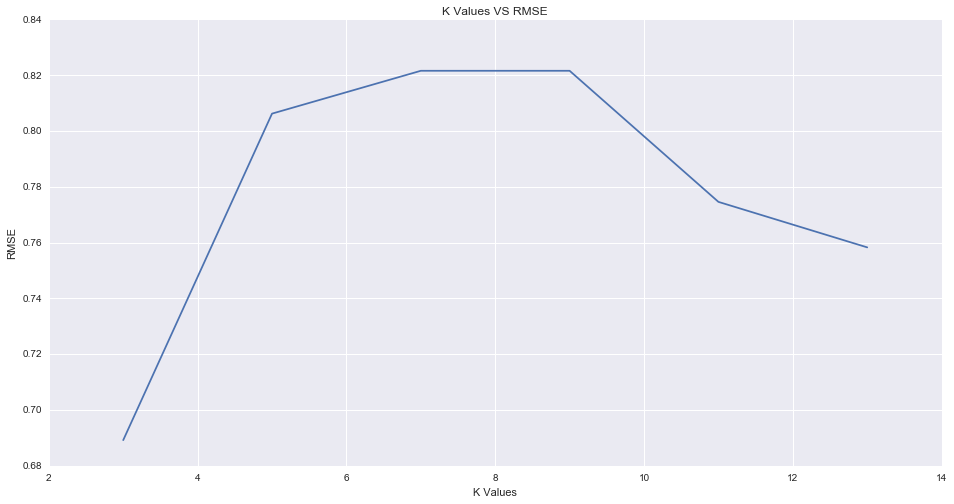

In [36]:
rmsess = [0.68920243760451105, 0.80622577482985502, 0.82158383625774922, 0.82158383625774922, 0.7745966692414834, 0.758287544405155]

plt.plot(range(3, 15, 2), rmsess)
plt.xlabel("K Values")
plt.ylabel("RMSE")
plt.title("K Values VS RMSE")
plt.show()

In [44]:
user1 = 17854
user2 = 31170

user_data = get_two_user_data(user1, user2)
intersection_list = get_intersection_list(user_data)
intersection_data = get_intersection_data(user_data, intersection_list)

user1Ratings = intersection_data[intersection_data['userID'] == user1].sort_values('movieID')['rating']
user2Ratings = intersection_data[intersection_data['userID'] == user2].sort_values('movieID')['rating']

distances = []

sse = 0

for item in intersection_list:
    rating1, rating2 = intersection_data[intersection_data['movieID'] == item]['rating']
    distance = np.linalg.norm(rating1 - rating2)
    sse += distance
    distances.append( distance )
print sse / len(intersection_list)


#plt.plot(xrange(len()))

0.960784313725


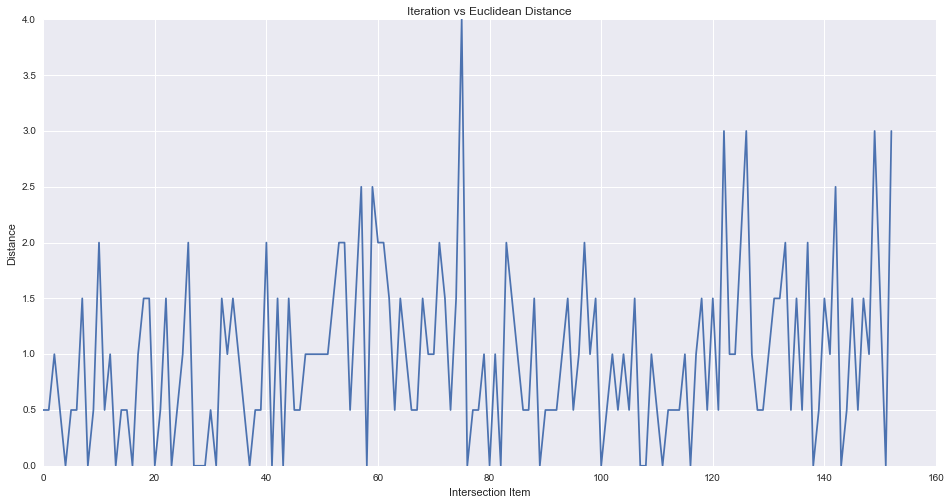

In [47]:
plt.plot(xrange(len(distances)), distances)
plt.xlabel("Intersection Item")
plt.ylabel("Distance")
plt.title("Iteration vs Euclidean Distance")
plt.show()

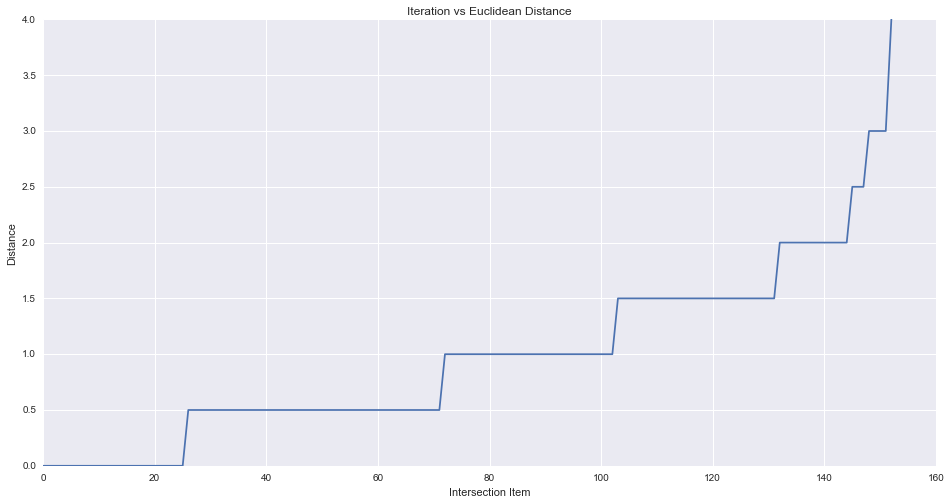

In [48]:
distances.sort()
plt.plot(xrange(len(distances)), distances)
plt.xlabel("Intersection Item")
plt.ylabel("Distance")
plt.title("Iteration vs Euclidean Distance")
plt.show()